In [1]:
import sys
sys.path.append('/opt/ml/code/stage1')

In [2]:
from stage1.utils import *
from stage1.modules.models import *
from stage1.trainer import *
import stage1.data

import torchvision

import timm

%matplotlib inline

# Utilities

# Models

In [3]:
effnet_b3_age = timm.models.efficientnet_b3(True)
effnet_b3_age.classifier = nn.Linear(
    effnet_b3_age.classifier.in_features, 3
)
setattr(effnet_b3_age, 'name', 'effnet_b3_age')

effnet_b3_age_logger = CSVLogger()

In [4]:
effnet_b3_gender = timm.models.efficientnet_b3(True)
effnet_b3_gender.classifier = nn.Linear(
    effnet_b3_gender.classifier.in_features, 2
)
setattr(effnet_b3_gender, 'name', 'effnet_b3_gender')

effnet_b3_gender_logger = CSVLogger()

In [5]:
effnet_b3_mask = timm.models.efficientnet_b3(True)
effnet_b3_mask.classifier = nn.Linear(
    effnet_b3_mask.classifier.in_features, 3
)
setattr(effnet_b3_mask, 'name', 'effnet_b3_mask')

effnet_b3_mask_logger = CSVLogger()

In [6]:
effnet_b0_1 = timm.models.efficientnet_b0(True)
effnet_b0_1.classifier = nn.Linear(effnet_b0_1.classifier.in_features, 18)
setattr(effnet_b0_1, 'name', 'effnet-b0-1')

freeze(effnet_b0_1, True, False)

effnet_b0_1_logger = CSVLogger()

In [7]:
effnet_b0_1a = timm.models.efficientnet_b0(True)
effnet_b0_1a.classifier = nn.Linear(effnet_b0_1a.classifier.in_features, 18)
setattr(effnet_b0_1a, 'name', 'effnet-b0-1a')

effnet_b0_1a_logger = CSVLogger()

In [8]:
effnet_b0_2da = timm.models.efficientnet_b0(True)
effnet_b0_2da.classifier = nn.Sequential(
    nn.Linear(effnet_b0_2da.classifier.in_features, 1024),
    nn.Dropout(0.5),
    nn.Linear(1024, 18)
)
setattr(effnet_b0_2da, 'name', 'effnet-b0-2da')

effnet_b0_2da_logger = CSVLogger()

In [9]:
effnet_b0_3da = timm.models.efficientnet_b0(True)
effnet_b0_3da.classifier = nn.Sequential(
    nn.Linear(effnet_b0_3da.classifier.in_features, 1024),
    nn.Dropout(0.5),
    nn.Linear(1024, 1024),
    nn.Dropout(0.5),
    nn.Linear(1024, 18)
)
setattr(effnet_b0_3da, 'name', 'effnet-b0-3da')

effnet_b0_3da_logger = CSVLogger()

# Configuration

In [10]:
# new config
config = ConfigTree()

In [11]:
!nvidia-smi

Mon Apr  5 10:36:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:00:05.0 Off |                  Off |
| N/A   42C    P8    13W / 250W |      0MiB / 24451MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [12]:
# device
config.system.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config.system.num_workers = 4

In [13]:
# path
config.path.input = os.path.join('/', 'opt', 'ml', 'input')
config.path.base = os.path.join(config.path.input, 'data')
config.path.train = os.path.join(config.path.base, 'train', '_all')
config.path.test = os.path.join(config.path.base, 'eval', 'images')

config.path.output = os.path.join('/', 'opt', 'ml', 'output')
config.path.models = os.path.join(config.path.output, 'models')
config.path.archive = os.path.join(config.path.models, 'archive')
config.path.configs = os.path.join(config.path.output, 'configs')
config.path.logs = os.path.join(config.path.output, 'logs')

config.path.pretrained = os.path.join(config.path.input, 'pretrained')

In [14]:
# data
config.data.valid_ratio = 0.2
config.data.valid_balanced = False
config.data.upscale = True
config.data.preprocess = False
config.data.crop_size = None
config.data.resize = None
'''
config.data.augment = ConfigBranch(
    train = False,
    test = False
)
'''
config.data.sampler = None   # not implemented yet
config.data.batch_size = 32

In [15]:
# hyperparameters for training
config.train.lr = ConfigBranch(
    base = 1e-3,
    backbone = 0,
    classifier = 0,
    scheduler = None,
    scheduler_kwarg = ConfigBranch(),
    few = 2,
    divider = 10,
    low_limit = 1e-6
)
config.train.weight_decay = 1e-4
config.train.betas = (0.9, 0.999)
config.train.momentum = 0.5
config.train.nesterov = False
config.train.loss = ConfigBranch(
    criterion = 'CrossEntropyLoss'
)
config.train.optimizer = ConfigBranch(
    name = 'AdamP',
    separate = False
)

In [16]:
# monitor settings
config.train.num_epochs = 10
config.train.valid_iters = 0

config.train.valid_min = 1
config.train.test_min = 1
config.train.save_min = 1

config.train.valid_period = 1
config.train.test_period = 0
config.train.save_period = 1
config.train.shuffle_period = 0
config.train.plot_period = 5

config.train.valid_min_acc = 0
config.train.test_min_acc = 1
config.train.save_min_acc = 0
config.train.plot_min_acc = 0

config.train.logger = CSVLogger()

In [17]:
# model
config.model = ConfigBranch(
    model = effnet_b0_1,
    classifying = 'all',
    state_path = ''
)

# Execution

In [18]:
trainer = Trainer(config)

In [19]:
MODELS_TO_TRAIN = [
    ConfigBranch(
        model = effnet_b0_1a,
        logger = effnet_b0_1a_logger, 
        classifying = 'all', 
        lr = 1e-4,
        state_path = '/opt/ml/output/models/2021-04-05 07:40:19.686058_effnet-b0-1a_upscaled.pth'
    ),
    ConfigBranch(
        model = effnet_b0_2da,
        logger = effnet_b0_2da_logger,
        classifying = 'all', 
        lr = 1e-4,
        state_path = 'opt/ml/output/models/2021-04-05 10:24:21.175193_effnet-b0-2da_upscaled.pth'
    ),
    ConfigBranch(
        model = effnet_b0_3da,
        logger = effnet_b0_3da_logger,
        classifying = 'all', 
        lr = 1e-3,
        state_path = ''
    ),
    ConfigBranch(
        model = effnet_b0_1,
        logger = effnet_b0_1_logger,
        classifying = 'all', 
        lr = 1e-3,
        state_path = ''
    ),
]

In [20]:
for branch in MODELS_TO_TRAIN:
    for name, param in branch.model.named_parameters():
        if 'fc' in name or 'classifier' in name:
            print(list(param.shape), '---', branch.model.name + '.' + name)

[18, 1280] --- effnet-b0-1a.classifier.weight
[18] --- effnet-b0-1a.classifier.bias
[1024, 1280] --- effnet-b0-2da.classifier.0.weight
[1024] --- effnet-b0-2da.classifier.0.bias
[18, 1024] --- effnet-b0-2da.classifier.2.weight
[18] --- effnet-b0-2da.classifier.2.bias
[1024, 1280] --- effnet-b0-3da.classifier.0.weight
[1024] --- effnet-b0-3da.classifier.0.bias
[1024, 1024] --- effnet-b0-3da.classifier.2.weight
[1024] --- effnet-b0-3da.classifier.2.bias
[18, 1024] --- effnet-b0-3da.classifier.4.weight
[18] --- effnet-b0-3da.classifier.4.bias
[18, 1280] --- effnet-b0-1.classifier.weight
[18] --- effnet-b0-1.classifier.bias


In [21]:
# model_iterator = iter(MODELS_TO_TRAIN)

# num_skip = 0
# for _ in range(num_skip):
#     branch = next(model_iterator)
# idx = MODELS_TO_TRAIN.index(branch)
# if idx < len(MODELS_TO_TRAIN) - 1:
#     print(f"Skipped {num_skip} model{'s' if num_skip > 1 else ''}. \
# Go to #{1 + idx}: {MODELS_TO_TRAIN[idx].model.name}:")
# else:
#     print(f"End of iteration.")

Successfully loaded state dict to model.
[INFO]
model=effnet-b0-1a
device=cuda:0(Tesla P40), epochs=10, batch size=32
optimizer.name=AdamP
learn rate=0.0001, weight decay=0.0001 betas=(0.9, 0.999)

Start of traning.
[Valid 010] (Batch #118)  Loss: 0.01841,  Acc: 99.4440
[Epoch 011] (Batch #1845)  Loss: 0.00663,  Acc: 99.792  (17:42)
[Valid 011] (Batch #118)  Loss: 0.00939,  Acc: 99.7620
Saved model: /opt/ml/output/models/2021-04-05 10:55:18.224442_effnet-b0-1a_upscaled.pth
[Epoch 012] (Batch #1845)  Loss: 0.00194,  Acc: 99.946  (17:46)
[Valid 012] (Batch #118)  Loss: 0.00815,  Acc: 99.8410
Saved model: /opt/ml/output/models/2021-04-05 11:13:23.768147_effnet-b0-1a_upscaled.pth
[Epoch 013] (Batch #1845)  Loss: 0.00097,  Acc: 99.975  (17:50)
[Valid 013] (Batch #118)  Loss: 0.00700,  Acc: 99.8410
Saved model: /opt/ml/output/models/2021-04-05 11:31:33.424015_effnet-b0-1a_upscaled.pth
[Epoch 014] (Batch #1845)  Loss: 0.00156,  Acc: 99.948  (17:46)
[Valid 014] (Batch #118)  Loss: 0.00680,  Ac

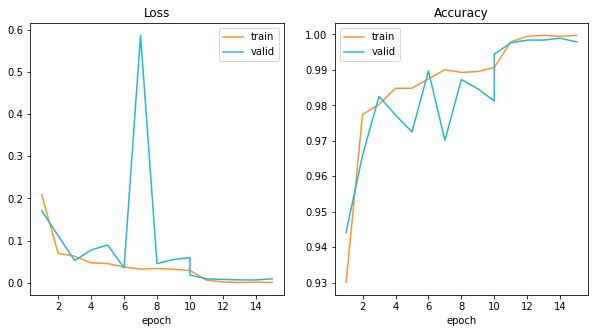

>>>>> Learning rate: 0.0001 -> 1e-05
[Epoch 016] (Batch #1845)  Loss: 0.00103,  Acc: 99.970  (17:42)
[Valid 016] (Batch #118)  Loss: 0.00805,  Acc: 99.8680
Saved model: /opt/ml/output/models/2021-04-05 12:25:37.401469_effnet-b0-1a_upscaled.pth
[Epoch 017] (Batch #1845)  Loss: 0.00120,  Acc: 99.963  (17:43)
[Valid 017] (Batch #118)  Loss: 0.00860,  Acc: 99.8940
Saved model: /opt/ml/output/models/2021-04-05 12:43:39.863684_effnet-b0-1a_upscaled.pth
>>>>> Learning rate: 1e-05 -> 1.0000000000000002e-06
[Epoch 018] (Batch #1845)  Loss: 0.00051,  Acc: 99.985  (17:39)
[Valid 018] (Batch #118)  Loss: 0.00885,  Acc: 99.8410
Saved model: /opt/ml/output/models/2021-04-05 13:01:38.276508_effnet-b0-1a_upscaled.pth
>>>>> Learning rate: 1.0000000000000002e-06 -> 1.0000000000000002e-07
>>>> Reached the lower limit for lerning rate.


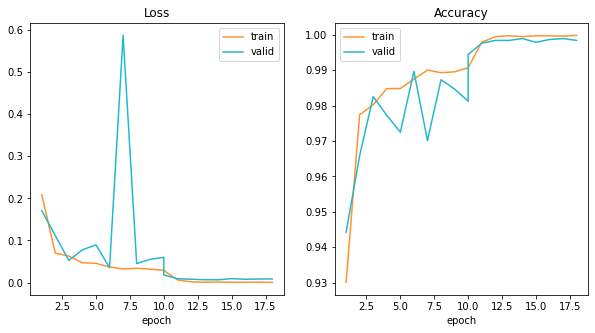


End of training. (end_lr=1.0000000000000002e-06)



In [22]:
MODEL_NUM = 0
branch = MODELS_TO_TRAIN[MODEL_NUM]

config.model.model = branch.model
config.train.logger = branch.logger
config.train.lr.base = branch.lr
config.train.weight_decay = 1e-4
config.model.classifying = branch.classifying
config.model.state_path = branch.state_path
trainer().load_state_dict_to_model()

newly_saved_state_dict = trainer.train_and_save()

branch.lr = trainer.lr
branch.state_path = newly_saved_state_dict

WARNITG: failed to load state dict - could not find the path.
[INFO]
model=effnet-b0-2da
device=cuda:0(Tesla P40), epochs=10, batch size=32
optimizer.name=AdamP
learn rate=0.0001, weight decay=0.0001 betas=(0.9, 0.999)

Start of traning.
[Valid 005] (Batch #118)  Loss: 2.93052,  Acc: 2.063
[Epoch 006] (Batch #1853)  Loss: 0.22800,  Acc: 92.903  (17:45)
[Valid 006] (Batch #118)  Loss: 0.06144,  Acc: 97.8570
Saved model: /opt/ml/output/models/2021-04-05 13:20:02.327458_effnet-b0-2da_upscaled.pth
[Epoch 007] (Batch #1853)  Loss: 0.02612,  Acc: 99.142  (17:47)
[Valid 007] (Batch #118)  Loss: 0.04315,  Acc: 98.7040
Saved model: /opt/ml/output/models/2021-04-05 13:38:09.215335_effnet-b0-2da_upscaled.pth
[Epoch 008] (Batch #1853)  Loss: 0.01865,  Acc: 99.452  (17:46)
[Valid 008] (Batch #118)  Loss: 0.05252,  Acc: 98.3600
Saved model: /opt/ml/output/models/2021-04-05 13:56:14.437054_effnet-b0-2da_upscaled.pth
>>>>> Learning rate: 0.0001 -> 1e-05
[Epoch 009] (Batch #1853)  Loss: 0.01368,  Acc: 

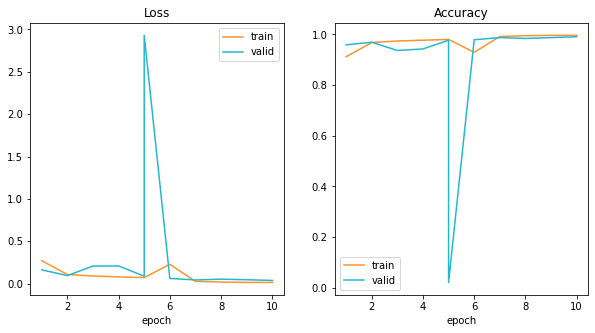

[Epoch 011] (Batch #1853)  Loss: 0.01128,  Acc: 99.656  (17:49)
[Valid 011] (Batch #118)  Loss: 0.03825,  Acc: 99.127
Saved model: /opt/ml/output/models/2021-04-05 14:50:42.547453_effnet-b0-2da_upscaled.pth
>>>>> Learning rate: 1e-05 -> 1.0000000000000002e-06
[Epoch 012] (Batch #1853)  Loss: 0.00890,  Acc: 99.737  (17:47)
[Valid 012] (Batch #118)  Loss: 0.03748,  Acc: 99.392
Saved model: /opt/ml/output/models/2021-04-05 15:08:48.910684_effnet-b0-2da_upscaled.pth
[Epoch 013] (Batch #1853)  Loss: 0.00823,  Acc: 99.750  (17:47)
[Valid 013] (Batch #118)  Loss: 0.04022,  Acc: 99.127
Saved model: /opt/ml/output/models/2021-04-05 15:26:55.606262_effnet-b0-2da_upscaled.pth
>>>>> Learning rate: 1.0000000000000002e-06 -> 1.0000000000000002e-07
>>>> Reached the lower limit for lerning rate.


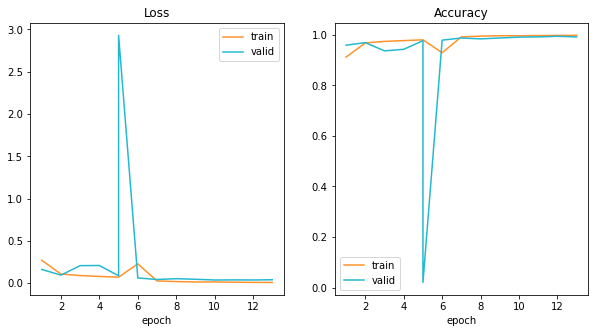


End of training. (end_lr=1.0000000000000002e-06)



In [23]:
MODEL_NUM = 1
branch = MODELS_TO_TRAIN[MODEL_NUM]

config.model.model = branch.model
config.train.logger = branch.logger
config.train.lr.base = branch.lr
config.train.weight_decay = 1e-4
config.model.classifying = branch.classifying
config.model.state_path = branch.state_path
trainer().load_state_dict_to_model()

newly_saved_state_dict = trainer.train_and_save()

branch.lr = trainer.lr
branch.state_path = newly_saved_state_dict

In [ ]:
MODEL_NUM = 2
branch = MODELS_TO_TRAIN[MODEL_NUM]

config.model.model = branch.model
config.train.logger = branch.logger
config.train.lr.base = branch.lr
config.train.weight_decay = 1e-4
config.model.classifying = branch.classifying
config.model.state_path = branch.state_path
trainer().load_state_dict_to_model()

newly_saved_state_dict = trainer.train_and_save()

branch.lr = trainer.lr
branch.state_path = newly_saved_state_dict

[INFO]
model=effnet-b0-3da
device=cuda:0(Tesla P40), epochs=10, batch size=32
optimizer.name=AdamP
learn rate=0.001, weight decay=0.0001 betas=(0.9, 0.999)

Start of traning.
[Epoch 001] (Batch #314)  Loss: 0.75094,  Acc: 75.030  (03:02)

In [ ]:
MODEL_NUM = 3
branch = MODELS_TO_TRAIN[MODEL_NUM]

config.model.model = branch.model
config.train.logger = branch.logger
config.train.lr.base = branch.lr
config.train.weight_decay = 1e-4
config.model.classifying = branch.classifying
config.model.state_path = branch.state_path
trainer().load_state_dict_to_model()

newly_saved_state_dict = trainer.train_and_save()

branch.lr = trainer.lr
branch.state_path = newly_saved_state_dict

# Ensemble

## Separate Predction

### By creating DataFrame

In [30]:
results = []
for branch in MODELS_TO_TRAIN:
    config.model.model = branch.model
    config.model.classifying = branch.classifying
    config.model.stae_path = branch.state_path
    trainer().load_state_dict_to_model()
    results.append(trainer.infer())

effnet_b3_age: End of evaluation (01:57)
effnet_b3_gender: End of evaluation (01:58)
effnet_b3_mask: End of evaluation (01:57)
effnet-b0-2a-raw: End of evaluation (01:01)


ValueError: too many values to unpack (expected 3)

In [31]:
ages, genders, masks, _ = results

In [38]:
ages = ages.loc[info.index]
genders = genders.loc[info.index]
masks = masks.loc[info.index]

In [39]:
info = pd.read_csv(
    os.path.join(config.path.output, 'info.csv'),
    index_col='ImageID'
)

assert (ages.index == info.index).all()
assert (genders.index == info.index).all()
assert (masks.index == info.index).all()

In [40]:
new_labels = pd.DataFrame(
    data={'ans': data.labels(ages.ans, genders.ans, masks.ans)},
    index=info.index
)
new_labels.head()

,ans
ImageID,
cbc5c6e168e63498590db46022617123f1fe1268.jpg,14
0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2
b549040c49190cedc41327748aeb197c1670f14d.jpg,14
4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13
248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12


In [41]:
prefix = "age+gender+mask_effnet_b3"
postfix = "raw"

csv_name = f"{prefix}_{name_from_datetime(datetime.today())}_{postfix}.csv"
csv_path = os.path.join(config.path.output, csv_name)

new_labels.to_csv(csv_path)

print(f"Saved inference: {csv_path}")

Saved inference: /opt/ml/output/age+gender+mask_effnet_b3_2021-04-05 00_08_57.925121_raw.csv


### By loading csv to DataFrame

In [ ]:
label_csv = ''
age_csv = ''
gender_csv = ''
mask_csv = ''

In [22]:
if label_csv:
    labels = pd.read_csv(label_csv, index_col='ImageID')

if age_csv:
    ages = pd.read_csv(age_csv, index_col='ImageID')
else:
    ages = pd.DataFrame(data={'ans': labels.ans.map(data.age_from_label)}, index=labels.index)
    
if gender_csv:
    genders = pd.read_csv(gender_csv, index_col='ImageID')
else:
    genders = pd.DataFrame(data={'ans': labels.ans.map(data.gender_from_label)}, index=labels.index)
    
if mask_csv: 
    masks = pd.read_csv(mask_csv, index_col='ImageID')
else:
    masks = pd.DataFrame(data={'ans': labels.ans.map(data.mask_from_label)}, index=labels.index)

info = pd.read_csv(
    os.path.join(config.path.output, 'info.csv'),
    index_col='ImageID'
)

assert (labels.index == info.index).all()
assert (ages.index == info.index).all()
assert (genders.index == info.index).all()
assert (masks.index == info.index).all()

AssertionError: 

In [25]:
new_labels = pd.DataFrame(
    data={'ans': data.labels(ages.ans, genders.ans, masks.ans)},
    index=labels.index
)
new_labels.head()

,ans
ImageID,
cbc5c6e168e63498590db46022617123f1fe1268.jpg,13
0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
b549040c49190cedc41327748aeb197c1670f14d.jpg,13
4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13
248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,13


In [85]:
prefix = "age+gender+mask_effnet_b3"
postfix = "raw"

csv_name = f"{prefix}_{name_from_datetime(datetime.today())}_{postfix}.csv"
csv_path = os.path.join(config.path.output, csv_name)

new_labels.to_csv(csv_path)

print(f"Saved inference: {csv_path}")

Saved inference: /opt/ml/output/effnet_b3_age_2021-04-04 11:24:09.680346.csv


## Ensemble of n(x/w)

### Inference of each model

In [20]:
models = []

for model in models:
    branch = next(model_iterator)
    model = branch.model
    model.load_state_dict(torch.load(branch.state_path, map_location=config.system.device))

print("<All keys have been matched.>")

<All keys have been matched.>


In [21]:
model_iterator = iter(MODELS_TO_TRAIN)
while True:
    try:
        branch = next(model_iterator)
        print(f"{branch.model.name}", end="")
        config.model.model = branch.model
        config.model.classifying = branch.classifying
        trainer.infer_and_save_csv()
    except StopIteration:
        break

End of evaluation (01:26)6)
Saved result: /opt/ml/output/effnet-b3_2021-04-04 10:27:31.516286.csv
End of evaluation (01:25)5)
Saved result: /opt/ml/output/effnet_b3_age_2021-04-04 10:28:57.290195.csv


### Ensemble!

In [34]:
# ensemble_and_infer_test(trainer, models, weighted=False)

Saved result: /opt/ml/output/ensemble_8x_2021-04-03 14:26:08.617512


# Result check and visualization

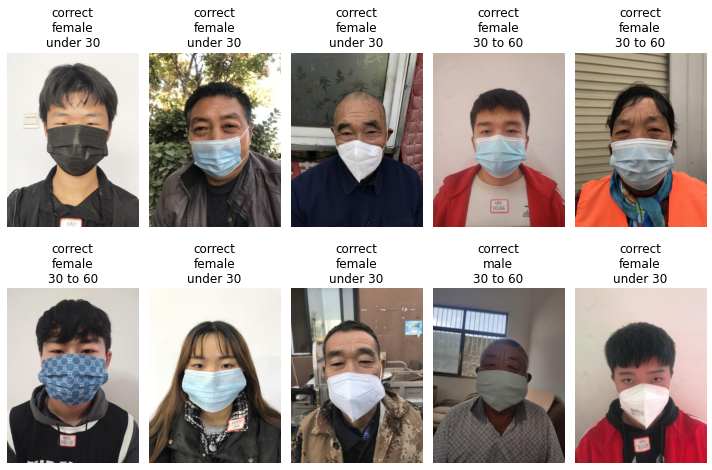

In [86]:
test_size = len(predictions)
num_samples = 10

predictions = new_labels

fig, axes = plt.subplots(
    num_samples // 5, 5, 
    figsize=(10, 5 * num_samples // 7)
)

for i, idx in enumerate(np.random.randint(0, test_size, num_samples)):
    filename = predictions.index[idx]
    prediction = predictions.iloc[idx].ans
    filepath = os.path.join(config.path.test, filename)
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.
    
    if prediction // 6 == 0:
        mask = 'correct'
    elif prediction // 6 == 1:
        mask = 'incorrect'
    elif prediction // 6 == 2:
        mask = 'not wear'
    else:
        raise "?"
    
    if (prediction // 3) % 2 == 0:
        gender = 'male'
    else:
        gender = 'female'
        
    if prediction % 3 == 0:
        age = 'under 30'
    elif prediction % 3 == 1:
        age = '30 to 60'
    else:
        age = '60 or more'
    
    r, c = divmod(i, 5)
    axes[r, c].imshow(image)
    axes[r, c].set_title(f"{mask}\n{gender}\n{age}", fontsize=12)
    axes[r, c].axis('off')
    
plt.tight_layout()
plt.show()